In [2]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import scipy as sp 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from data_loader import ACSEmploymentDataset
from folk_utils import format_params, initialize_base_model, set_protected_groups_by_input, set_protected_groups_config, intialize_splits_with_cluster_labels, predict_with_subdomain_model


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
#! brew install lightgbm

In [4]:
#! pip install --upgrade threadpoolctl

In [5]:
folktables_state = 'GA'
folktables_year = 2018

seed_lst = [100, 200, 300, 400, 500, 600]
num_clusters_lst = [1, 2, 3, 4, 5, 6, 7, 8]

base_models = {
    'rf': RandomForestClassifier(random_state=0),
    'lgbm': LGBMClassifier(random_state=0)
}

rf_random_grid = {'learner__n_estimators': [100, 200, 500, 700, 1000],
               'learner__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
               'learner__min_samples_split': [2, 5, 10],
               'learner__min_samples_leaf': [1, 2, 4],
               'learner__bootstrap': [True, False]}

lgbm_random_grid = {
                'learner__max_depth' : [i for i in range(3,12)],
                'learner__num_leaves' : [int(x) for x in np.linspace(start = 20, stop = 3000, num = 10)],
                'learner__min_data_in_leaf' : [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
}

params = {
    'rf': rf_random_grid,
    'lgbm': lgbm_random_grid
}

In [6]:
folk = ACSEmploymentDataset(state=[folktables_state], year=folktables_year, with_nulls=False, optimize=False, subsample = 20000)

/Users/falaaharifkhan/Documents/subdomain-modelling/subdomain_folktables/data_loader.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[self.target] = acs_data[self.target].apply(lambda x: int(x == 1))


In [7]:
folk.dataset

AGEP  SCHL  MAR  RELP  DIS  ESP  CIT  MIG  MIL  ANC  NATIVITY  DEAR  \
59368    63  22.0    1     1    2  0.0    1  1.0  4.0    1         1     2   
56175     5   2.0    5     2    2  3.0    1  3.0  0.0    3         1     2   
65320    42  22.0    1     1    2  0.0    1  1.0  4.0    4         1     2   
62516    36  22.0    1     0    2  0.0    4  1.0  4.0    1         2     2   
84064    54  21.0    5     0    2  0.0    1  1.0  4.0    4         1     2   
...     ...   ...  ...   ...  ...  ...  ...  ...  ...  ...       ...   ...   
40107    84  18.0    1     0    2  0.0    1  1.0  2.0    1         1     2   
82037    14  10.0    5     2    2  7.0    1  1.0  0.0    1         1     2   
33776     6   3.0    5     2    2  7.0    1  1.0  0.0    1         1     2   
55410    48  19.0    3     0    2  0.0    1  1.0  4.0    1         1     2   
64941    16  13.0    5     2    2  1.0    1  1.0  0.0    2         1     2   

       DEYE  DREM  SEX  RAC1P  ESR  
59368     2   2.0    2      1    1  
56175     2   2.0    1      1    0  
65320     2   2.0    2      1    1  
62516     2   2.0    1      6    0  
84064     2   2.0    1      1    1  
...     ...   ...  ...    ...  ...  
40107     2   2.0    1      1    1  
82037     2   2.0    1      2    0  
33776     2   2.0    2      2    0  
55410     2   2.0    2      2    1  
64941     2   2.0    2      1    0  

[20000 rows x 17 columns]

In [8]:
import json
f = open('best_params_folk.json')
saved_params_after_tuning = json.load(f)

In [9]:
res_df = {"seed": [], "model_name": [], "accuracy": [], "f1_score":[], "n_clusters": []}
best_params = {"seed": [], "train_group":[], "params":[], "training_time": []}

In [10]:
encoder = ColumnTransformer(transformers=[
                        ('categorical_features', OneHotEncoder(categories='auto', handle_unknown='ignore'), folk.categorical_columns),
                        ('numerical_features', StandardScaler(), folk.numerical_columns)])

for SEED in seed_lst:
    print(SEED)
    for num_clusters in  num_clusters_lst:
        protected_groups = set_protected_groups_config(num_clusters)
        train_group_names = list(protected_groups.keys())
        train, test = intialize_splits_with_cluster_labels(SEED=SEED, k=num_clusters, dataset=folk, test_size=0.2)
        train_groups = set_protected_groups_by_input(train, protected_groups) 
        test_groups = set_protected_groups_by_input(test, protected_groups) 
        
        for model_name in ['rf', 'lgbm']:
            trained_models = {}
            
            for i, train_group in enumerate(train_groups.keys()):
                model = Pipeline([
                                    ('features', encoder),
                                    ('learner', base_models[model_name])
                        ])
                search = RandomizedSearchCV(estimator = model, param_distributions = params[model_name], n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
                search.fit(train_groups[train_group][folk.features], train_groups[train_group][folk.target])
                best_params["seed"].append(SEED)
                best_params["train_group"].append(train_group)
                best_params["params"].append(search.best_params_)
                
                t_init = datetime.now()
                trained_models[train_group] = search.best_estimator_
                #trained_models[train_group] = initialize_base_model(model_name, search.best_params_, SEED=SEED+i)
                trained_models[train_group].fit(train_groups[train_group][folk.features], train_groups[train_group][folk.target])
                t_end = datetime.now()
                best_params["training_time"] = (t_end - t_init).seconds
            
            y_true, y_pred = predict_with_subdomain_model(trained_models, train_group_names, test_groups, folk.features, folk.target)
            res_df["seed"].append(SEED)
            res_df["model_name"].append(model_name)
            res_df["accuracy"].append(accuracy_score(y_true, y_pred))
            res_df["f1_score"].append(f1_score(y_true, y_pred))
            #res_df["training_time"].append(train_time)
            res_df["n_clusters"].append(num_clusters)

100
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   3.5s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   3.6s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   3.6s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=  10.3s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=  10.4s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=  10.4s
[CV] END learner__bootstr

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   3.9s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   3.9s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   5.2s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=  11.0s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=  11.0s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   4.1s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   4.2s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   4.1s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   8.8s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   8.9s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   2.2s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   2.4s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   4.1s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   4.2s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   4.3s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   2.6s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   2.6s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   4.5s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   4.5s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   4.6s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   0.8s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   0.8s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   1.1s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   1.1s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   1.2s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   0.9s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   0.9s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   1.5s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   1.5s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   1.5s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   1.6s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   1.6s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   2.3s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   2.3s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   2.3s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   4.0s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   4.0s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   4.2s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=  11.8s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=  11.8s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=  12.0s
[CV] END learner__bootstr

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   2.7s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   2.7s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   4.2s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   4.3s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   4.3s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   2.2s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   2.2s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   4.1s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   4.1s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   4.1s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   1.7s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   1.7s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   2.7s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   2.8s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   2.8s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   1.6s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   1.6s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   2.5s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   2.5s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   2.6s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   1.4s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   1.4s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   2.1s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   2.1s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   2.1s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   5.0s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   5.2s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   7.0s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   7.0s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   7.1s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   1.0s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   1.0s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   1.2s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   1.2s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   1.2s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   5.2s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   5.3s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   5.6s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=  15.8s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=  15.8s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   3.3s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   3.3s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   5.0s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   5.2s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   5.4s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   2.8s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner__n_estimators=200; total time=   2.8s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   4.9s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   5.0s
[CV] END learner__bootstrap=True, learner__max_depth=80, learner__min_samples_leaf=2, learner__min_samples_split=2, learner__n_estimators=200; total time=   5.0s
[CV] END learner__bootstrap=False, learner__max_depth=10, learner__min_samples_leaf=1, learner__min_samples_split=5, learner_

KeyboardInterrupt: 

In [11]:
results = pd.DataFrame(res_df)

In [12]:
results

seed model_name  accuracy  f1_score  n_clusters
0    100         rf   0.83125  0.824721           1
1    100       lgbm   0.82925  0.822459           1
2    100         rf   0.83175  0.825873           2
3    100       lgbm   0.83100  0.823314           2
4    100         rf   0.82900  0.822798           3
5    100       lgbm   0.82625  0.819808           3
6    100         rf   0.82950  0.822765           4
7    100       lgbm   0.82475  0.817590           4
8    100         rf   0.83075  0.825200           5
9    100       lgbm   0.82050  0.813990           5
10   100         rf   0.82775  0.821549           6
11   100       lgbm   0.82075  0.813330           6
12   100         rf   0.82775  0.821641           7
13   100       lgbm   0.81750  0.811272           7
14   100         rf   0.82700  0.821281           8
15   100       lgbm   0.81950  0.813050           8
16   200         rf   0.82950  0.817354           1
17   200       lgbm   0.83150  0.819109           1
18   200         rf   0.83225  0.819478           2
19   200       lgbm   0.82700  0.813678           2
20   200         rf   0.82900  0.816720           3
21   200       lgbm   0.82475  0.811204           3
22   200         rf   0.82950  0.816864           4
23   200       lgbm   0.82550  0.811249           4
24   200         rf   0.83075  0.820377           5
25   200       lgbm   0.82775  0.815430           5
26   200         rf   0.82725  0.815487           6
27   200       lgbm   0.82500  0.811117           6
28   200         rf   0.82825  0.816751           7
29   200       lgbm   0.82025  0.806252           7
30   200         rf   0.82950  0.817354           8
31   200       lgbm   0.82250  0.807796           8
32   300         rf   0.82025  0.809839           1
33   300       lgbm   0.82450  0.815166           1
34   300         rf   0.82350  0.813228           2
35   300       lgbm   0.82350  0.813326           2

<AxesSubplot: xlabel='n_clusters', ylabel='accuracy'>

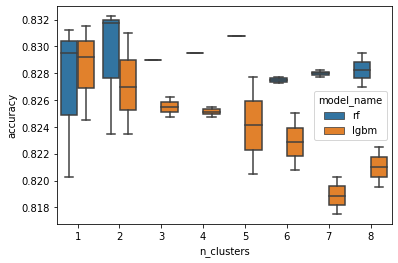

In [13]:
sns.boxplot(data=results, x='n_clusters', y='accuracy', hue='model_name')

<AxesSubplot: xlabel='n_clusters', ylabel='f1_score'>

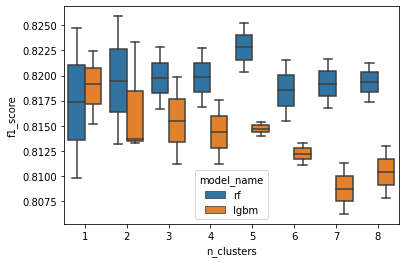

In [14]:
sns.boxplot(data=results, x='n_clusters', y='f1_score', hue='model_name')

In [15]:
sns.boxplot(data=results, x='n_clusters', y='training_time', hue='model_name')

ValueError: Could not interpret input 'training_time'